# Mission - Classifiez automatiquement des informations

Vous êtes mandaté en tant que Consultant Data Scientist par le département RH de votre client. Il s’agit de l'ESN TechNova Partners, spécialisée dans le conseil en transformation digitale et la vente d’applications en SaaS.
 
Ils font face à un turnover plus élevé que d'habitude et ils souhaitent identifier les causes racines potentielles derrière ces démissions.

### Importation des librairies

In [18]:
# Librairies "classiques"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display

# Librairies scikit-learn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
# Preprocess et modèles
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### On reprend les éléments du précédent notebook

In [3]:
donnees_modelisation = pd.read_csv("../Data/Projet_4_etape2_clean.csv")

# Partie 3 - Réalisation d'un premier modèle de classification

### Recommandations de l'étape 3 :
* Commencer par réaliser une séparation train test simple ou une validation croisée simple.

* Commencer par entraîner d’abord un modèle Dummy, puis un modèle linéaire, avant d'entraîner un modèle non-linéaire. Cela vous permettra d’évaluer la difficulté et la “non-linéarité” du jeu de données.
* Concernant le modèle non-linéaire, nous recommandons d’utiliser des modèles à base d’arbre (RandomForest, XGBoost ou CatBoost sont les plus connus).
* A minima, vous devez calculer les métriques d’évaluation incontournables en classification : matrice de confusion, rappel et précision. Le classification_report() de sklearn peut vous aider.
* Interpréter la performance du modèle sur la base des scores (présence d’overfit ou non, capacité d’éviter les faux positifs ou faux négatifs) et du modèle étalon Dummy.

##### Dans un premier temps, nous allons procéder à une validation croisée sur un modèle Dummy pour avoir une base de comparaison. 

### Test sur le modèle DummyClassifier

DummyClassifier est un classificateur qui fait des prédictions à l'aide de règles simples.

In [4]:
# Colonnes à scaler ou déjà encodées
features_a_scaler = [
    'revenu_mensuel','annee_experience_totale','annees_dans_l_entreprise','distance_domicile_travail',
    'annees_depuis_la_derniere_promotion','experience_externe','score_satisfaction',
    'augmentation_par_formation','pee_par_anciennete','niveau_education']
features_encodees = [
    'genre','heure_supplementaires',
    'frequence_deplacement','a_suivi_formation','tranche_age','statut_marital_Celibataire',
    'statut_marital_Divorce','statut_marital_Marie','promotion_recente','poste_AssistantdeDirection',
    'poste_CadreCommercial','poste_Consultant','poste_DirecteurTechnique','poste_Manager',
    'poste_ReprésentantCommercial','poste_RessourcesHumaines','poste_SeniorManager','poste_TechLead']

# Séparation de X et y
y = donnees_modelisation["a_quitte_l_entreprise"]
X = donnees_modelisation.drop(columns = "a_quitte_l_entreprise")

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify=y)

# Scaling ou non de mes features
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), features_a_scaler),
        ('cat', 'passthrough', features_encodees)
    ]
)
# Ajout dans un Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DummyClassifier(strategy='most_frequent'))
])
# Enregistrement de nos indicateurs
scoring = ['accuracy','precision','recall','f1']

cv_results = cross_validate(
    pipeline,
    X_train, y_train,            
    cv=3,
    scoring=scoring,
    return_train_score=True
)

# Fit sur l'ensemble d'entraînement
pipeline.fit(X_train, y_train)

# Prédictions
y_pred_train = pipeline.predict(X_train)
y_pred_test  = pipeline.predict(X_test)

# Classification reports
print("Classification Report — TRAIN")
print(classification_report(y_train, y_pred_train))

print("Classification Report — TEST")
print(classification_report(y_test, y_pred_test))

Classification Report — TRAIN
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       986
           1       0.00      0.00      0.00       190

    accuracy                           0.84      1176
   macro avg       0.42      0.50      0.46      1176
weighted avg       0.70      0.84      0.76      1176

Classification Report — TEST
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294



/Users/florianschorer/OpenClassrooms Project/Classifiez_automatiquement_des_informations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/florianschorer/OpenClassrooms Project/Classifiez_automatiquement_des_informations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/florianschorer/OpenClassrooms Project/Classifiez_automatiquement_des_informations/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-

#### Réalisation de notre matrice de confusion pour DummyClassifier

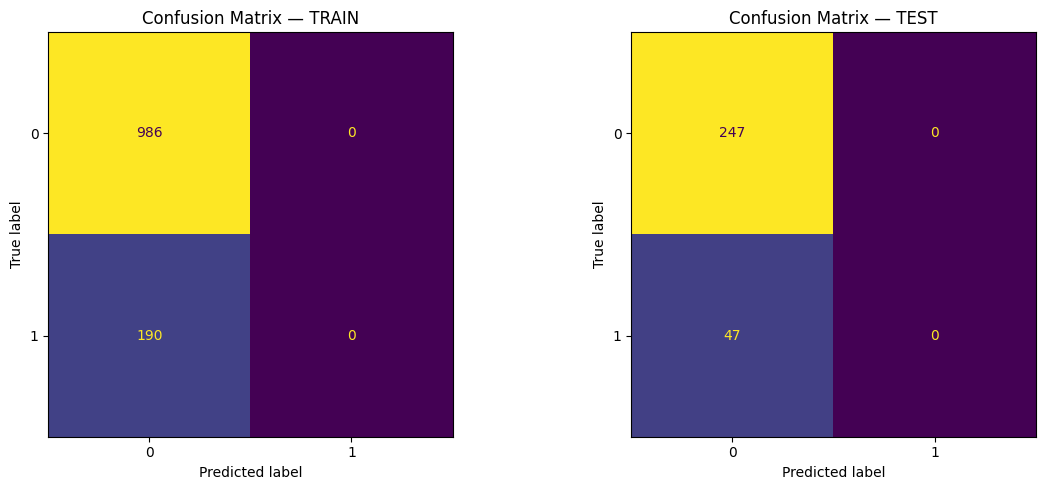

In [5]:
classes = sorted(y.unique())

cm_train = confusion_matrix(y_train, y_pred_train, labels=classes)
cm_test  = confusion_matrix(y_test,  y_pred_test,  labels=classes)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_train, display_labels=classes).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix — TRAIN")

ConfusionMatrixDisplay(cm_test, display_labels=classes).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix — TEST")

plt.tight_layout()
plt.show()

Avant d'interpréter nos indicateurs, une petite définition pour chaque.

* Accuracy : C’est le pourcentage de prédictions correctes (tous labels confondus). Exemple : "Parmi tous les employés, combien ai-je bien classés ?”

* Precison : Mesure la fiabilité des prédictions positives. Exemple : “Sur tous ceux que je pense quitter l’entreprise, combien quittent vraiment ?”
* Recall : Mesure la capacité à ne pas rater de cas positifs. Exemple “Sur tous les départs réels, combien ai-je détectés ?”
* F1-score : C’est une moyenne entre Precision et Recall.
* Support : Nombre d’échantillons de la classe considérée.
* Macro avg : Moyenne non pondérée des scores des classes. Chaque classe compte de la même façon, peu importe sa taille.
* Weighted avg : Moyenne pondérée par le support (effectif de chaque classe).

Interprétation des résultats de DummyClassifier
* C'est ce qu'on attend d'un modèle de ce type, il va nous servir de base. Nous avons un dataset déséquilibré, 84% des salariés sont restés, et nous avons un accuracy de 84%, cela correspond.
* Le modèle prédit toujours la classe majoritaire (0) : Accuracy ≈ 84%. Classe 1 complètement ignorée (recall = 0, precision = 0, F1 = 0). Macro average  bas (≈0.42–0.50), car une des classes est sacrifiée.

Sur la matrice de confusion :
* Dans les 2 cas le modèle n'a pas prédit de 1.
* Le DummyClassifier prédit toujours la classe majoritaire (0).

### Test sur le modèle LogisticRegression

In [6]:
# Colonnes à scaler ou déjà encodées
features_a_scaler = [
    'revenu_mensuel','annee_experience_totale','annees_dans_l_entreprise','distance_domicile_travail',
    'annees_depuis_la_derniere_promotion','experience_externe','score_satisfaction',
    'augmentation_par_formation','pee_par_anciennete','niveau_education']
features_encodees = [
    'genre','heure_supplementaires',
    'frequence_deplacement','a_suivi_formation','tranche_age','statut_marital_Celibataire',
    'statut_marital_Divorce','statut_marital_Marie','promotion_recente','poste_AssistantdeDirection',
    'poste_CadreCommercial','poste_Consultant','poste_DirecteurTechnique','poste_Manager',
    'poste_ReprésentantCommercial','poste_RessourcesHumaines','poste_SeniorManager','poste_TechLead']

# Séparation de X et y
y = donnees_modelisation["a_quitte_l_entreprise"]
X = donnees_modelisation.drop(columns = "a_quitte_l_entreprise")

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify=y)

# Scaling ou non de mes features
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), features_a_scaler ),
        ('cat', 'passthrough', features_encodees)
    ]
)
# Ajout dans un Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
])
# Enregistrement de nos indicateurs
scoring = ['accuracy','precision','recall','f1']

cv_results = cross_validate(
    pipeline,
    X_train, y_train,            
    cv=3,
    scoring=scoring,
    return_train_score=True # On inclut les scores du train
)

# Fit sur l'ensemble d'entraînement
pipeline.fit(X_train, y_train)

# Prédictions
y_pred_train = pipeline.predict(X_train)
y_pred_test  = pipeline.predict(X_test)

# Classification reports
print(" Classification Report — TRAIN")
print(classification_report(y_train, y_pred_train))

print("Classification Report — TEST")
print(classification_report(y_test, y_pred_test))

 Classification Report — TRAIN
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       986
           1       0.80      0.35      0.49       190

    accuracy                           0.88      1176
   macro avg       0.84      0.67      0.71      1176
weighted avg       0.87      0.88      0.86      1176

Classification Report — TEST
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       247
           1       0.82      0.30      0.44        47

    accuracy                           0.88       294
   macro avg       0.85      0.64      0.68       294
weighted avg       0.87      0.88      0.85       294



Interprétation du classfication report :
* Accuracy : train 0.880 vs val 0.881. Le modèle classe correctement environ 88 % des salariés, aussi bien sur train que sur validation. L’écart train/val est quasi nul : pas d’overfitting. On peut noter également un meilleur score d'accuracy pour le modèle de régression logistique que notre étalon Dummy.

* Precision : train 0.786 vs val 0.791. Quand le modèle prédit “Oui” (départ), il a raison environ 8 fois sur 10. Donc peu de faux positifs (il ne se trompe pas souvent en disant qu’un salarié part).
* Recall : train 0.355 vs val 0.358. Mais il ne détecte qu’environ 1 salarié sur 3 qui part réellement. Beaucoup de faux négatifs : le modèle loupe une majorité des départs.
* F1 : train 0.488 | val 0.492. Le compromis précision/rappel est moyen.

#### Réalisation de notre matrice de confusion pour LogisticRegression

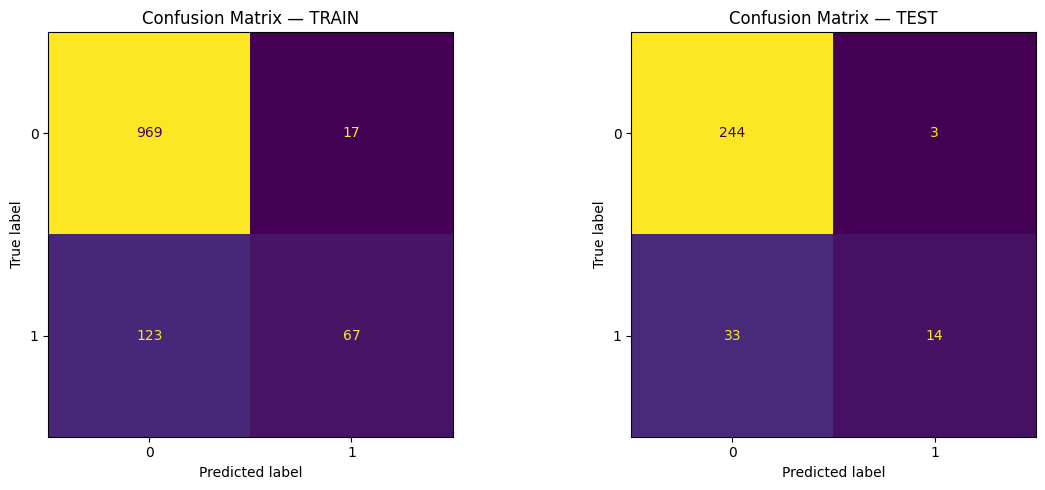

In [7]:
classes = sorted(y.unique())

# Matrices de confusion
cm_train = confusion_matrix(y_train, y_pred_train, labels=classes)
cm_test  = confusion_matrix(y_test,  y_pred_test,  labels=classes)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_train, display_labels=classes).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix — TRAIN")

ConfusionMatrixDisplay(cm_test, display_labels=classes).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix — TEST")

plt.tight_layout()
plt.show()

Sur la matrice de confusion :
* La classe 0 est bien gérée (presque 100% de recall).
* La classe 1 est détectée mais encore faiblement (environ 30% de recall).
* Le modèle est conservateur : très peu de FP, mais beaucoup de FN.
* C’est mieux que le Dummy (qui n’avait aucun TP), mais ça reste déséquilibré.

#### Nous décidons de tester deux modèles non linéaires :
* RandomForest
* XGBoost

### Modèle non-linéaire RandomForestClassifier

In [16]:
# Colonnes à scaler ou déjà encodées
features_a_scaler = [
    'revenu_mensuel','annee_experience_totale','annees_dans_l_entreprise','distance_domicile_travail',
    'annees_depuis_la_derniere_promotion','experience_externe','score_satisfaction',
    'augmentation_par_formation','pee_par_anciennete','niveau_education']
features_encodees = [
    'genre','heure_supplementaires',
    'frequence_deplacement','a_suivi_formation','tranche_age','statut_marital_Celibataire',
    'statut_marital_Divorce','statut_marital_Marie','promotion_recente','poste_AssistantdeDirection',
    'poste_CadreCommercial','poste_Consultant','poste_DirecteurTechnique','poste_Manager',
    'poste_ReprésentantCommercial','poste_RessourcesHumaines','poste_SeniorManager','poste_TechLead']

# Séparation de X et y
y = donnees_modelisation["a_quitte_l_entreprise"]
X = donnees_modelisation.drop(columns="a_quitte_l_entreprise")

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Scaling ou non de mes features
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), features_a_scaler),
        ('cat', 'passthrough', features_encodees)
    ]
)
# Ajout dans un Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',RandomForestClassifier())
])
# Enregistrement de nos indicateurs
scoring = ['accuracy','precision','recall','f1']

cv_results = cross_validate(
    pipeline,
    X_train, y_train,            
    cv=3,
    scoring=scoring,
    return_train_score=True
)
# Fit sur l'ensemble d'entraînement
pipeline.fit(X_train, y_train)

# Prédictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Classification reports
print("Classification Report - TRAIN")
print(classification_report(y_train, y_pred_train))

print("Classification Report — TEST")
print(classification_report(y_test, y_pred_test))


Classification Report - TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       978
           1       1.00      1.00      1.00       198

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

Classification Report — TEST
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       255
           1       0.60      0.08      0.14        39

    accuracy                           0.87       294
   macro avg       0.74      0.53      0.53       294
weighted avg       0.84      0.87      0.82       294



Interprétation des résultats du RandomForestClassifier :

* Train = 1.00 partout : RandomForest overfit.
* Test (classe 1) : precision 0.60, recall 0.08 = le modèle rate presque tous les “1” (énormément de FN).
* Accuracy élevée (0.87) car la classe 0 domine : trompeuse.


#### Réalisation de notre matrice de confusion pour LogisticRegression

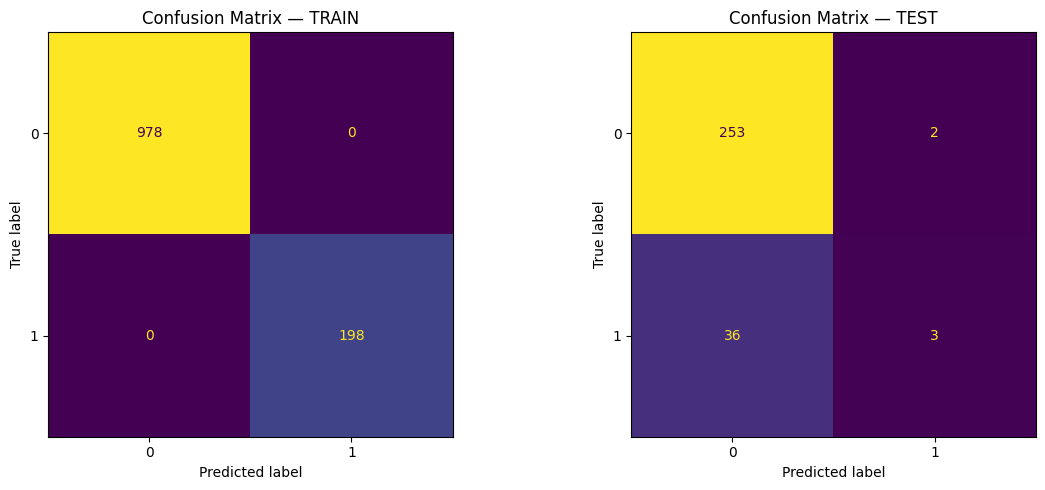

In [17]:
classes = sorted(y.unique())

# Matrices de confusion
cm_train = confusion_matrix(y_train, y_pred_train, labels=classes)
cm_test  = confusion_matrix(y_test,  y_pred_test,  labels=classes)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_train, display_labels=classes).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix — TRAIN")

ConfusionMatrixDisplay(cm_test, display_labels=classes).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix — TEST")

plt.tight_layout()
plt.show()

On remarque clairement un overfit, l'entraînement est correct alors que dans la validation nous avons par exemple que 3 vrais positif. Le déséquilibre est flagrant ici aussi.

### Modèle non-linéaire de XGBoost

In [19]:
# Colonnes à scaler ou déjà encodées
features_a_scaler = [
    'revenu_mensuel','annee_experience_totale','annees_dans_l_entreprise','distance_domicile_travail',
    'annees_depuis_la_derniere_promotion','experience_externe','score_satisfaction',
    'augmentation_par_formation','pee_par_anciennete','niveau_education']
features_encodees = [
    'genre','heure_supplementaires',
    'frequence_deplacement','a_suivi_formation','tranche_age','statut_marital_Celibataire',
    'statut_marital_Divorce','statut_marital_Marie','promotion_recente','poste_AssistantdeDirection',
    'poste_CadreCommercial','poste_Consultant','poste_DirecteurTechnique','poste_Manager',
    'poste_ReprésentantCommercial','poste_RessourcesHumaines','poste_SeniorManager','poste_TechLead']

# Séparation de X et y
y = donnees_modelisation["a_quitte_l_entreprise"]
X = donnees_modelisation.drop(columns="a_quitte_l_entreprise")

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Scaling ou non de mes features
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), features_a_scaler),
        ('cat', 'passthrough', features_encodees)
    ]
)
# Ajout dans un Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',XGBClassifier())
])
# Enregistrement de nos indicateurs
scoring = ['accuracy','precision','recall','f1']

cv_results = cross_validate(
    pipeline,
    X_train, y_train,            
    cv=3,
    scoring=scoring,
    return_train_score=True
)
# Fit sur l'ensemble d'entraînement
pipeline.fit(X_train, y_train)

# Prédictions
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

# Classification reports
print("Classification Report - TRAIN")
print(classification_report(y_train, y_pred_train))

print("Classification Report — TEST")
print(classification_report(y_test, y_pred_test))


Classification Report - TRAIN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       978
           1       1.00      1.00      1.00       198

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

Classification Report — TEST
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       255
           1       0.40      0.21      0.27        39

    accuracy                           0.85       294
   macro avg       0.64      0.58      0.59       294
weighted avg       0.82      0.85      0.83       294



Interprétation des résultats de XGBoost

* XGBoost overfit, comme RandomForest
* Il gère très bien les “Non”, mais rate la majorité des “Oui”.

### Matrice de confusion pour XGBoost

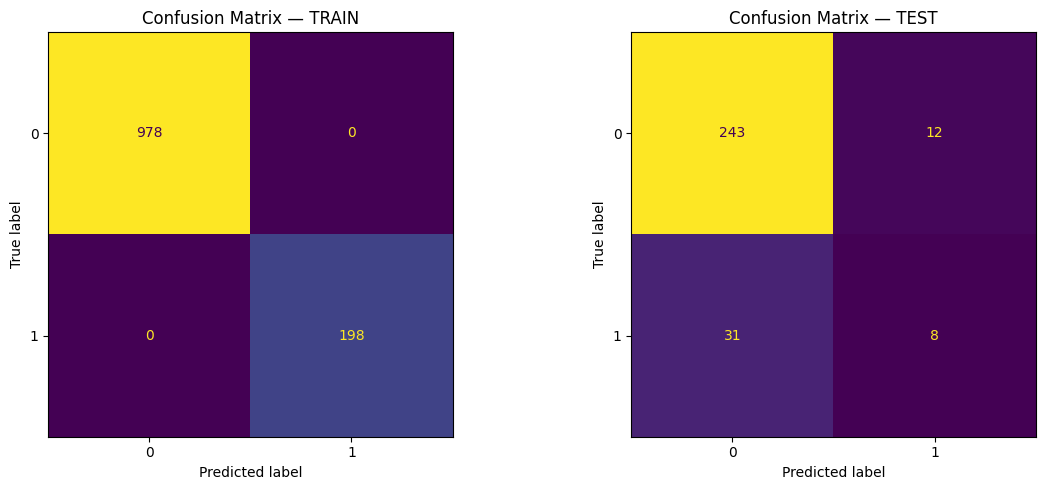

In [20]:
classes = sorted(y.unique())

# Matrices de confusion
cm_train = confusion_matrix(y_train, y_pred_train, labels=classes)
cm_test  = confusion_matrix(y_test,  y_pred_test,  labels=classes)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(cm_train, display_labels=classes).plot(ax=axes[0], colorbar=False)
axes[0].set_title("Confusion Matrix — TRAIN")

ConfusionMatrixDisplay(cm_test, display_labels=classes).plot(ax=axes[1], colorbar=False)
axes[1].set_title("Confusion Matrix — TEST")

plt.tight_layout()
plt.show()

* On voit que le nombre de TP est encore trop faible. On note cependant une légère augmentation de captation des Oui que RandomForest. Par contre nous avons une moins bonne précision que le RandomForest.

## Petite conclusion

* On analyse facilement que les résultats sont tronqués par le déséquilibre de notre jeu de données. Les différents modèles captent essentiellement seulement les non-départs, ce qui n'est pas étonnant car nous avons répartition de 84% pour les non-départs.
* On note la présence d'overfit pour les modèles de RandomForest et XGBoost.
* Que ce soit pour le modèle de régression Logistique, de RandomForest ou XGBoost, on voit que ces modèles ont un meilleur accuracy que le modèle étalon, Dummy. Ce qui est rassurant, les modèles font mieux qu'un modèle de base. 

* Lors de la prochaine étape nous devrons effectuer des ajustements sur ce déséquilibre afin de capter le plus de Oui possible.
